In [1]:
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import random
import copy
import math


## TSP Problem

In [2]:

class TSPProblem:
    def __init__(self, cities):
        self.cities = cities
        self.num_cities = len(cities)

    def distance(self, city1, city2):
        return np.linalg.norm(np.array(city1) - np.array(city2))

    def total_distance(self, solution):
        total_dist = 0
        for i in range(len(solution) - 1):
            if i + 1 < len(solution):
                total_dist += self.distance(self.cities[solution[i]], self.cities[solution[i + 1]])
        # Add distance from last city back to the starting city
        if len(solution) > 0:
            total_dist += self.distance(self.cities[solution[-1]], self.cities[solution[0]])
        return total_dist


## Methods

### Greedy

In [3]:
class TSPGreedy:
    def __init__(self, problem):
        self.problem = problem
        self.best_solution = None

    def optimize(self):
        num_cities = self.problem.num_cities
        unvisited = list(range(num_cities))
        current_city = random.choice(unvisited)
        unvisited.remove(current_city)
        solution = [current_city]

        while unvisited:
            next_city = min(unvisited, key=lambda city: self.problem.distance(self.problem.cities[current_city], self.problem.cities[city]))
            unvisited.remove(next_city)
            solution.append(next_city)
            current_city = next_city
        self.best_solution = solution
 
        return solution, self.problem.total_distance(solution)

### 2 opt

In [4]:
class TwoOpt_TSP:
    def __init__(self, tsp_problem):
        self.tsp_problem = tsp_problem
        self.best_solution = None

    def two_opt(self):
        tour = list(range(self.tsp_problem.num_cities))
        #let us shuffle the tour
        random.shuffle(tour)
        
        best_tour = tour
        improved = True
        while improved:
            improved = False
            for i in range(1, len(tour) - 2):
                for j in range(i + 1, len(tour)):
                    #if j - i == 1:
                      # continue  # No need to consider adjacent edges
                    new_tour = tour[:i] + tour[i:j][::-1] + tour[j:]
                    if self.tsp_problem.total_distance(new_tour) < self.tsp_problem.total_distance(best_tour):
                        best_tour = new_tour
                        tour = new_tour 
                        improved = True
        self.best_solution = best_tour
          
        return best_tour, self.tsp_problem.total_distance(best_tour)


### 3 opt

In [5]:
class ThreeOpt_TSP:
    def __init__(self, tsp_problem,  num_iterations=10000,init_tour=None):
        self.tsp_problem = tsp_problem
        self.num_cities = tsp_problem.num_cities
        self.num_iterations = num_iterations
        self.init_tour=init_tour
    
        
    def three_opt_swap(self, tour, i, j, k):
        new_tour = tour[:i] + tour[i:j][::-1] + tour[j:k][::-1] + tour[k:]
        return new_tour

    def improve_tour(self, tour):
        
        improved = True
        while improved:
            improved = False
            for i in range(self.num_cities - 4):
                for j in range(i + 2, self.num_cities-2):
                    for k in range(j + 2, self.num_cities):
                        new_tour = self.three_opt_swap(tour, i, j, k)
                        if self.tsp_problem.total_distance(new_tour) < self.tsp_problem.total_distance(tour):
                            tour = new_tour
                            improved = True
            #if not improved:
             # break
        return tour

    def run(self):
        if self.init_tour is not None:
            initial_tour = self.init_tour
        else:
            initial_tour = list(range(self.num_cities))
            random.shuffle(initial_tour)
        improved_tour = self.improve_tour(initial_tour)
        best_distance = self.tsp_problem.total_distance(improved_tour)
        return improved_tour, best_distance


### Simulated Annealing (SA)

In [6]:
class TSPSimulatedAnnealing:
    def __init__(self, problem, initial_temperature=1000, cooling_rate=0.99):
        self.problem = problem
        self.initial_temperature = initial_temperature
        self.cooling_rate = cooling_rate
        self.costs = []

    def acceptance_probability(self, current_distance, new_distance, temperature):
        if new_distance < current_distance:
            return 1
        return math.exp((current_distance - new_distance) / temperature)

    def optimize(self, max_iterations):
        current_solution = list(range(self.problem.num_cities))
        random.shuffle(current_solution)
        best_solution = current_solution
        temperature = self.initial_temperature

        for iteration in range(max_iterations):
            # Randomly select two indices for swapping
            i, j = random.sample(range(self.problem.num_cities), 2)
            new_solution = copy.deepcopy(current_solution)
            new_solution[i], new_solution[j] = new_solution[j], new_solution[i]

            current_distance = self.problem.total_distance(current_solution)
            new_distance = self.problem.total_distance(new_solution)

            # Accept or reject the new solution based on acceptance probability
            if random.random() < self.acceptance_probability(current_distance, new_distance, temperature):
                current_solution = new_solution

            # Update best solution if necessary
            if self.problem.total_distance(current_solution) < self.problem.total_distance(best_solution):
                best_solution = current_solution

            # Cool down temperature
            temperature *= self.cooling_rate

            # Record cost
            self.costs.append(self.problem.total_distance(best_solution))
            
            # Print progress
            if iteration % 500 == 0:
                print("Iteration:", iteration, "Distance:", self.problem.total_distance(best_solution), "Temperature:", temperature)

        return best_solution, self.problem.total_distance(best_solution), self.costs

### Tabu Search (TS)

In [7]:
class TabuSearchTSP:
    def __init__(self, tsp_problem, num_iterations=100, tabu_size=40):
        self.tsp_problem = tsp_problem
        self.num_iterations = num_iterations
        self.tabu_size = tabu_size
        self.best_solution = None
        self.hist_best_distance=float('inf')
        
        self.costs=[]
        self.best_solution = list(range(self.tsp_problem.num_cities))

    def evaluate_solution(self, solution):
        return self.tsp_problem.total_distance(solution)

    def apply_swap(self, solution, i, j):
        new_solution = solution[:]
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
        return new_solution

    def generate_neighbors(self, solution):
        neighbors = []
        num_cities = self.tsp_problem.num_cities
        for i in range(num_cities):
            for j in range(i + 1, num_cities):
                neighbor = self.apply_swap(solution, i, j)
                neighbors.append(neighbor)
        return neighbors

    def run(self):
        initial_tour = list(range(self.tsp_problem.num_cities))
        random.shuffle(initial_tour)
        current_solution = initial_tour
        self.best_solution = current_solution
        best_solution = current_solution
        tabu_list = []
        for iter in range(self.num_iterations):
            # Generate candidate solutions
            candidate_solutions = self.generate_neighbors(current_solution)
            # Evaluate candidate solutions
            candidate_solutions_eval = [(sol, self.evaluate_solution(sol)) for sol in candidate_solutions]
            # Sort candidate solutions by evaluation value
            candidate_solutions_eval.sort(key=lambda x: x[1])
            # Find the best non-tabu solution
            for sol, _ in candidate_solutions_eval:
                if sol not in tabu_list:
                    best_solution = sol
                    break
            # Update current solution
            current_solution = best_solution
            # Update tabu list
            if best_solution not in tabu_list:
                tabu_list.append(best_solution)
            if len(tabu_list) > self.tabu_size:
                tabu_list.pop(0)
                
            
            best_distance = self.evaluate_solution(best_solution)
           
            if best_distance < self.hist_best_distance:
                self.best_solution = best_solution
                self.hist_best_distance = best_distance
                
            self.costs.append(self.hist_best_distance)
            if iter % 10 == 0:
                print("Iteration:", iter, "Best Distance:", self.hist_best_distance)
            
        return self.best_solution, self.evaluate_solution(self.best_solution)

### Genetic Algorithm (GA)

In [8]:


class GA_TSP:
    def __init__(self, tsp_problem, pop_size=400, mutation_rate=0.1, generations=200, initial_tour =None):
        self.tsp_problem = tsp_problem
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.initial_tour = initial_tour
        self.population = self.initial_population()
        self.costs = []
        self.best_solution = list(range(self.tsp_problem.num_cities))

    def initial_population(self):
        population = []
        for _ in range(self.pop_size):
            if self.initial_tour is None:
                
                individual = list(range(self.tsp_problem.num_cities))
                random.shuffle(individual)
                
            else:
                individual = [x for  x in self.initial_tour]
                self.best_solution = individual
            population.append(individual)
        return population

    def fitness(self, individual):
        return 1 / self.tsp_problem.total_distance(individual)

    def select_parents(self):
        # Tournament selection
        tournament_size = 10
        selected_parents = []
        for _ in range(2):  # Select two parents
            tournament = random.sample(self.population, tournament_size)
            fittest_individual = max(tournament, key=self.fitness)
            selected_parents.append(fittest_individual)
            
        return selected_parents

    def crossover(self, parent1, parent2):
        # Order 1 Crossover
        start, end = sorted(random.sample(range(self.tsp_problem.num_cities), 2))
        child = [None] * self.tsp_problem.num_cities
        child[start:end + 1] = parent1[start:end + 1]
        parent2_remaining = [item for item in parent2 if item not in child]
        child = [parent2_remaining.pop(0) if x is None else x for x in child]
        return child

    def mutate(self, individual):
        # Swap mutation
        if random.random() < self.mutation_rate:
            i, j = random.sample(range(self.tsp_problem.num_cities), 2)
            individual[i], individual[j] = individual[j], individual[i]
        return individual

    def evolve(self):
        new_population = []
        for _ in range(self.pop_size):
            parents = self.select_parents()
            child = self.crossover(parents[0], parents[1])
            child = self.mutate(child)
            new_population.append(child)
        self.population = new_population

    def run(self):
        for _ in range(self.generations):
            self.evolve()
            # record the progress
            current_cost = self.tsp_problem.total_distance(max(self.population, key=self.fitness))
         
            
            if current_cost < self.tsp_problem.total_distance(self.best_solution):
                self.best_solution = max(self.population, key=self.fitness)
                
            self.costs.append(self.tsp_problem.total_distance(self.best_solution))
            if _ % 10 == 0:
                print("Generation:", _, "Best Distance:", self.tsp_problem.total_distance(self.best_solution))
            
     
        
        return self.best_solution, self.tsp_problem.total_distance(self.best_solution)

### Ant Colony Optimization (ACO)

In [9]:

class ACO_TSP:
    def __init__(self, tsp_problem, num_ants=100, num_iterations=250, alpha=1.0, beta=2.0, rho=0.1,  q=100.0, initial_pheromone=1.0):
        self.tsp_problem = tsp_problem
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha  # Pheromone factor
        self.beta = beta    # Heuristic factor
        self.rho = rho      # Pheromone evaporation rate
        self.q = q          # Pheromone deposit factor
        self.initial_pheromone = initial_pheromone
        self.pheromone_matrix = np.ones((tsp_problem.num_cities, tsp_problem.num_cities)) * initial_pheromone
        self.best_solution = None
        self.best_distance = float('inf')
        self.costs=[]

    def ant_tour(self, start_city):
        visited = [start_city]
        remaining = list(range(self.tsp_problem.num_cities))
        remaining.remove(start_city)

        while remaining:
            probabilities = self.calculate_probabilities(visited[-1], remaining)
            next_city = random.choices(remaining, weights=probabilities)[0]
            visited.append(next_city)
            remaining.remove(next_city)
        
        visited.append(start_city)
        distance=self.tsp_problem.total_distance(visited)
        return visited, distance

    def calculate_probabilities(self, current_city, remaining):
        probabilities = []
        for city in remaining:
            pheromone = self.pheromone_matrix[current_city][city]
            heuristic = 1 / self.tsp_problem.distance(self.tsp_problem.cities[current_city], self.tsp_problem.cities[city])
            probability = (pheromone ** self.alpha ) * (heuristic ** self.beta)
            probabilities.append(probability)
        
        total = sum(probabilities)
        probabilities = [p / total for p in probabilities]
        return probabilities

    def update_pheromones(self, tours):
        pheromone_delta = np.zeros_like(self.pheromone_matrix)
        for tour, distance in tours:
            for i in range(len(tour) - 1):
                city1, city2 = tour[i], tour[i + 1]
                pheromone_delta[city1][city2] += self.q / distance
                pheromone_delta[city2][city1] += self.q / distance
        self.pheromone_matrix = (1 - self.rho) * self.pheromone_matrix + pheromone_delta

    def run(self):
        for iteration in range(self.num_iterations):
            tours = []
            for ant in range(self.num_ants):
                #start_city = random.randint(0, self.tsp_problem.num_cities - 1)
                start_city = 0
                tour, distance = self.ant_tour(start_city)
                tours.append((tour, distance))
                
                if distance < self.best_distance:
                    self.best_solution = tour
                    self.best_distance = distance
                    
            self.costs.append(self.best_distance)
            self.update_pheromones(tours)
            if iteration % 10 == 0:
                print("Iteration:", iteration, "Best Distance:", self.best_distance)
        
        return self.best_solution, self.best_distance

### Cross Entropy (CE)

In [65]:
class CrossEntropyTSP:
    def __init__(self, costs, c, rho, d, alpha, seed):
        self.costs = costs
        self.n = len(costs)
        self.N = c * self.n**2
        self.rho = rho
        self.d = d
        self.alpha = alpha
        self.random_state = np.random.RandomState(seed)
        self.init_transition_mat()
        self.cost_hist=[]

        self.best_solution = np.array(list(range(self.n)))
        self.best_distance = 99999999


    def init_transition_mat(self):
        p_ij = 1 / (self.n - 1)
        trans_mat = np.full_like(self.costs, p_ij, float)
        np.fill_diagonal(trans_mat, 0)
        self.trans_mat = trans_mat
        self.trans_mat_old = trans_mat

    def generate_path(self):
        trans_mat = self.trans_mat.copy()
        path = [0]
        for k in range(self.n - 1):
            trans_mat[:, path[-1]] = 0
            row_sum = trans_mat.sum(axis=1)
            
            with np.errstate(invalid='ignore', divide='ignore'):
                trans_mat = (trans_mat.T / row_sum).T
                
            choice = self.random_state.choice(np.arange(self.n), p=trans_mat[path[-1], :])
            path.append(choice)
        path.append(0)
        return path

    def generate_paths(self):
        return [self.generate_path() for _ in range(self.N)]

    def score(self, path):
        costs = [self.costs[path[k], path[k+1]] for k in range(len(path) - 1)]
        return sum(costs)

    def calculate_scored_paths(self):
        paths = self.generate_paths()
        scores = list(map(self.score, paths))
        scored_paths = list(zip(scores, paths))
        self.scored_paths = sorted(scored_paths, key=lambda x: x[0])


    def highest_score(self):
        return self.scored_paths[0][0]

    
    def high_scored_paths(self):
        rho_quantile_idx = int(self.rho * self.N)
        return self.scored_paths[:rho_quantile_idx+1]


    def smoothly_update_transition_mat(self):
        self.trans_mat_old = self.trans_mat.copy()
        trans_mat = np.zeros_like(self.trans_mat)

        for scored_path in self.high_scored_paths():
            for idx in range(self.n - 1):
                i = scored_path[1][idx]
                j = scored_path[1][idx+1]
                trans_mat[i, j] += 1

        trans_mat = trans_mat / len(self.high_scored_paths())
        self.trans_mat = self.alpha * trans_mat + (1 - self.alpha) * self.trans_mat_old

    def shortest_path(self):
        self.init_transition_mat()
        
        highest_scores = []
       
        while_cond = True
        t = 0
        
        while while_cond:
            self.calculate_scored_paths()
            
            highest_scores.append(self.highest_score())
          
            if t >= self.d-1:
                while_cond = False
            
            
            self.smoothly_update_transition_mat()
            t += 1
            
            #print progress
            if t%10 == 0:
                print("Iteration:", t, "Best Distance:", self.highest_score())
            
            if self.highest_score() < self.best_distance:
                self.best_solution = self.scored_paths[0][1]
                self.best_distance = self.highest_score()
            self.cost_hist.append(self.best_distance)
            
    
        return self.scored_paths[0][1]


## experiments

### att48

In [67]:
file_name = "data/att48.txt"
data=[]
with open(file_name, "r") as f:
    for line in f:
        data.append((line.strip()))

cities=[]
for i in data:
    lst = i.split(" ")
    lst=[x for x in lst if x != '']
   
    x,y =int(lst[1]), int(lst[2])
    cities.append((x,y))
    
from scipy.spatial import distance_matrix

costs_matrix = distance_matrix(cities, cities) 

file_name = "data/att48_soln.txt"
data_soln=[]
with open(file_name, "r") as f:
    for line in f:
        data_soln.append((line.strip()))
optimal_soln_= []
for i in data_soln:
    optimal_soln_.append(int(i))
optimal_soln_=optimal_soln_[:-1]
optimal_soln_ =[x-1 for x in optimal_soln_]

tsp_problem = TSPProblem(cities)

optimal_soln_distance = tsp_problem.total_distance(optimal_soln_)
optimal_soln_distance

33523.70850743559

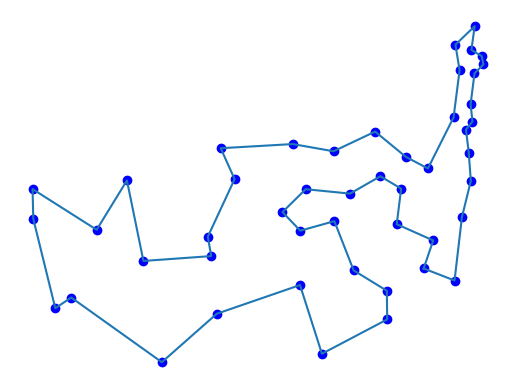

In [11]:

def plot_tour(tour,cities,title):
    cities = np.array([list(city) for city in cities])
    tour = list(tour)
    #plt.figure(figsize=(40, 15))
    plt.plot(*zip(*cities[tour+[tour[0]]]))
    plt.scatter(*zip(*cities), c='b')
    #plt.scatter(*cities[0], c='r', s=100)
    plt.axis('off')
    plt.savefig(title+ '.jpg',  bbox_inches='tight', dpi=200)
    plt.show()
    
plot_tour(optimal_soln_,cities,'optimal solution of att48')

#### CE

In [68]:
repeticiones = 5
print("Cross Entropy")  
records=[]
# repet the expeiement 5 times
for _ in range(repeticiones):
    cem_tsp = CrossEntropyTSP(costs=costs_matrix , c=1, rho=0.1, d=100, alpha=0.5, seed=np.random.randint(0, 1000))

    # Optimize TSP using Greedy algorithm
    best_solution = cem_tsp.shortest_path()
    best_distance = tsp_problem.total_distance(best_solution)   

    #print progress
    records.append(best_distance)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
    
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Cross Entropy
Iteration: 10 Best Distance: 71343.36194541666
Iteration: 20 Best Distance: 53818.26274767486
Iteration: 30 Best Distance: 47440.58648065153
Iteration: 40 Best Distance: 43846.86778283826
Iteration: 50 Best Distance: 42666.18862754321
Iteration: 60 Best Distance: 39123.933891572444
Iteration: 70 Best Distance: 37767.19718540415
Iteration: 80 Best Distance: 36060.105834577786
Iteration: 90 Best Distance: 34596.63858382577
Iteration: 100 Best Distance: 34779.35237578136
Repeticione: 0 Best Distance: 34779.35237578136
Iteration: 10 Best Distance: 68931.9591174573
Iteration: 20 Best Distance: 48455.044320396184
Iteration: 30 Best Distance: 50032.98602839969
Iteration: 40 Best Distance: 47978.52481946123
Iteration: 50 Best Distance: 43435.17415530092
Iteration: 60 Best Distance: 41253.81745978284
Iteration: 70 Best Distance: 37362.44143326502
Iteration: 80 Best Distance: 36540.1404642804
Iteration: 90 Best Distance: 36142.48253011628
Iteration: 100 Best Distance: 36142.4825301

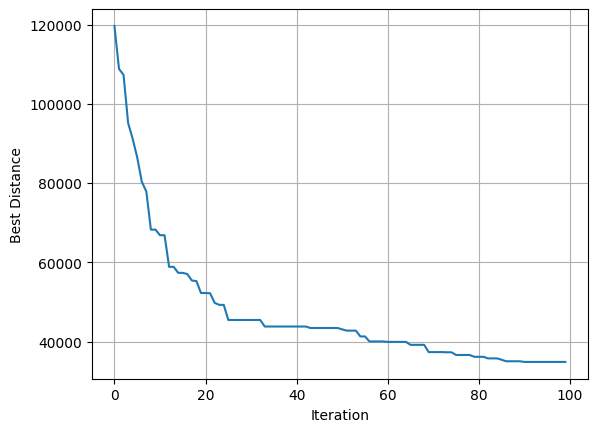

In [69]:

plt.plot(range(len(cem_tsp.cost_hist)),cem_tsp.cost_hist)
plt.xlabel('Iteration')
plt.ylabel('Best Distance')
#plt.xscale('log')
plt.grid(True)
plt.show()

#### greedy

In [12]:
repeticiones = 5
print("Greedy Algorithm")
records=[]
# repet the expeiement 5 times
for _ in range(repeticiones):
    tsp_greedy = TSPGreedy(tsp_problem)

    # Optimize TSP using Greedy algorithm
    best_solution, best_distance = tsp_greedy.optimize()

    #print progress
    records.append(best_distance)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Greedy Algorithm
Repeticione: 0 Best Distance: 42153.575353788496
Repeticione: 1 Best Distance: 42444.59853374978
Repeticione: 2 Best Distance: 40880.21915419291
Repeticione: 3 Best Distance: 40899.643249972214
Repeticione: 4 Best Distance: 40899.643249972214
Averaged best distance  41455.53590833512
Min best distance  40880.21915419291
Max best distance  42444.59853374978
Error 0.2366035189436229


#### 2 opt

In [13]:
print("Two Opt Algorithm")
records=[]
# repet the expeiement 5 times
for _ in range(repeticiones):
    local_search_tsp =TwoOpt_TSP(tsp_problem)

    # Optimize TSP using 2-opt local search
    best_tour, best_distance = local_search_tsp.two_opt()

    records.append(best_distance)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Two Opt Algorithm


Repeticione: 0 Best Distance: 39771.34032154705
Repeticione: 1 Best Distance: 35708.58960196477
Repeticione: 2 Best Distance: 39768.53347525176
Repeticione: 3 Best Distance: 37006.71015895809
Repeticione: 4 Best Distance: 40887.21533744356
Averaged best distance  38628.47777903305
Min best distance  35708.58960196477
Max best distance  40887.21533744356
Error 0.15227340586335228


#### 3 opt

In [14]:
print("Three Opt Algorithm")

records=[]
record_soln=[]
for _ in range(repeticiones):
    three_opt_tsp = ThreeOpt_TSP(tsp_problem)
# Find optimal TSP tour using 3-Opt heuristic
    best_tour, best_distance = three_opt_tsp.run()
    records.append(best_distance)
    record_soln.append(best_tour)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Three Opt Algorithm
Repeticione: 0 Best Distance: 37310.138320542115
Repeticione: 1 Best Distance: 37705.2487700311
Repeticione: 2 Best Distance: 36928.426041764375
Repeticione: 3 Best Distance: 36393.65496716458
Repeticione: 4 Best Distance: 36356.16170650824
Averaged best distance  36938.72596120208
Min best distance  36356.16170650824
Max best distance  37705.2487700311
Error 0.10186872532342392


#### SA

In [15]:
print('Simulated Annealing Algorithm')
records=[]
for _ in range(repeticiones):
    tsp_sa = TSPSimulatedAnnealing(tsp_problem)
    best_solution, best_distance, costs = tsp_sa.optimize(max_iterations=15000)
    records.append(best_distance)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Simulated Annealing Algorithm
Iteration: 0 Distance: 161357.00440249636 Temperature: 990.0
Iteration: 500 Distance: 69235.51515909369 Temperature: 6.504778211990453
Iteration: 1000 Distance: 56228.72214204504 Temperature: 0.04273953493655127
Iteration: 1500 Distance: 53352.99845701676 Temperature: 0.0002808193895412968
Iteration: 2000 Distance: 52315.061717395016 Temperature: 1.845119036962312e-06
Iteration: 2500 Distance: 50559.182617525476 Temperature: 1.2123323343597228e-08
Iteration: 3000 Distance: 48121.02509014707 Temperature: 7.965609044681468e-11
Iteration: 3500 Distance: 45842.0292091883 Temperature: 5.233789915058397e-13
Iteration: 4000 Distance: 45807.272341180855 Temperature: 3.438852788445183e-15
Iteration: 4500 Distance: 45461.63816885157 Temperature: 2.2594923931839235e-17
Iteration: 5000 Distance: 45461.63816885157 Temperature: 1.4845956453879764e-19
Iteration: 5500 Distance: 44074.69613929115 Temperature: 9.754510512864258e-22
Iteration: 6000 Distance: 43786.0438454809

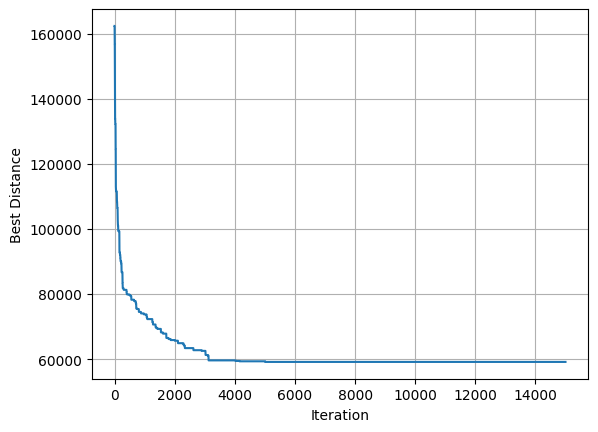

In [16]:
plt.plot(range(len(tsp_sa.costs)), tsp_sa.costs)
plt.xlabel('Iteration')
plt.ylabel('Best Distance')

#plt.xscale('log')
plt.grid(True)
plt.show()

#### TS

In [17]:
print("Tabu Search Algorithm")
records=[]
for _ in range(repeticiones):

    ts_tsp = TabuSearchTSP(tsp_problem,num_iterations=200)
    best_solution, best_distance = ts_tsp.run()
    records.append(best_distance)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Tabu Search Algorithm
Iteration: 0 Best Distance: 143651.90154514098
Iteration: 10 Best Distance: 76822.9690480105
Iteration: 20 Best Distance: 58962.32304304134
Iteration: 30 Best Distance: 51066.56872457999
Iteration: 40 Best Distance: 49558.21968411822
Iteration: 50 Best Distance: 49433.352923553015
Iteration: 60 Best Distance: 49108.72439320372
Iteration: 70 Best Distance: 45423.548060008914
Iteration: 80 Best Distance: 43282.692360205074
Iteration: 90 Best Distance: 42950.4250717285
Iteration: 100 Best Distance: 42757.834645217314
Iteration: 110 Best Distance: 42757.834645217314
Iteration: 120 Best Distance: 42757.834645217314
Iteration: 130 Best Distance: 42757.834645217314
Iteration: 140 Best Distance: 42757.834645217314
Iteration: 150 Best Distance: 42757.834645217314
Iteration: 160 Best Distance: 42757.834645217314
Iteration: 170 Best Distance: 42757.834645217314
Iteration: 180 Best Distance: 42757.834645217314
Iteration: 190 Best Distance: 42757.834645217314
Repeticione: 0 Be

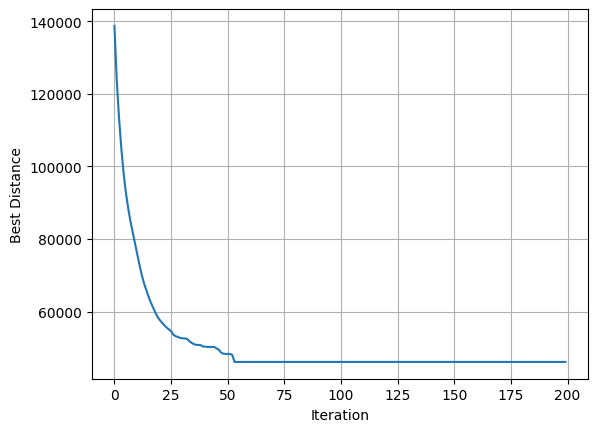

In [18]:

plt.plot(range(len(ts_tsp.costs)),ts_tsp.costs)
plt.xlabel('Iteration')
plt.ylabel('Best Distance')
#plt.xscale('log')
plt.grid(True)
plt.show()

#### GA

In [19]:
print("Genetic Algorithm")

records=[]
for _ in range(repeticiones):
   ga_tsp = GA_TSP(tsp_problem,generations=200)
   best_solution, best_distance = ga_tsp.run()
   records.append(best_distance)
   print("Repeticione:", _ , "Best Distance:",  best_distance )
   
   
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Genetic Algorithm
Generation: 0 Best Distance: 111742.36085268385
Generation: 10 Best Distance: 78193.25420834564
Generation: 20 Best Distance: 61527.03692605978
Generation: 30 Best Distance: 52420.86668780617
Generation: 40 Best Distance: 46063.87902023422
Generation: 50 Best Distance: 44858.84186138417
Generation: 60 Best Distance: 42231.29657930176
Generation: 70 Best Distance: 41581.11287455975
Generation: 80 Best Distance: 41581.11287455975
Generation: 90 Best Distance: 41411.610657161815
Generation: 100 Best Distance: 41152.493143502594
Generation: 110 Best Distance: 41152.493143502594
Generation: 120 Best Distance: 41152.493143502594
Generation: 130 Best Distance: 41152.493143502594
Generation: 140 Best Distance: 41077.28162146754
Generation: 150 Best Distance: 41077.28162146754
Generation: 160 Best Distance: 41077.28162146754
Generation: 170 Best Distance: 41077.28162146754
Generation: 180 Best Distance: 41077.28162146754
Generation: 190 Best Distance: 41077.28162146754
Repetic

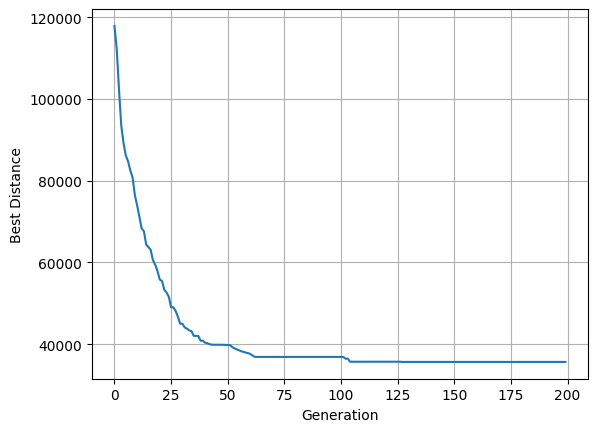

In [20]:
plt.plot(range(len(ga_tsp.costs)), ga_tsp.costs)
plt.xlabel('Generation')
plt.ylabel('Best Distance')

#plt.xscale('log')
plt.grid(True)
plt.show()

#### ACO

In [21]:
print("Ant Colony Optimization Algorithm")  
records=[]
record_soln=[]
for _ in range(repeticiones):
   
   aco_tsp = ACO_TSP(tsp_problem,num_iterations=250)
   best_solution, best_distance = aco_tsp.run()
   records.append(best_distance)
   record_soln.append(best_solution)
   print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Ant Colony Optimization Algorithm
Iteration: 0 Best Distance: 57791.98278416582
Iteration: 10 Best Distance: 46565.691344518214
Iteration: 20 Best Distance: 45285.36030944197
Iteration: 30 Best Distance: 40799.39151257005
Iteration: 40 Best Distance: 38822.7253993257
Iteration: 50 Best Distance: 37251.61212127521
Iteration: 60 Best Distance: 37251.61212127521
Iteration: 70 Best Distance: 36037.1881347841
Iteration: 80 Best Distance: 36037.1881347841
Iteration: 90 Best Distance: 36037.1881347841
Iteration: 100 Best Distance: 36037.1881347841
Iteration: 110 Best Distance: 35396.68212415533
Iteration: 120 Best Distance: 35300.584740576596
Iteration: 130 Best Distance: 35300.584740576596
Iteration: 140 Best Distance: 35300.584740576596
Iteration: 150 Best Distance: 35300.584740576596
Iteration: 160 Best Distance: 35300.584740576596
Iteration: 170 Best Distance: 35300.584740576596
Iteration: 180 Best Distance: 35300.584740576596
Iteration: 190 Best Distance: 35300.584740576596
Iteration: 20

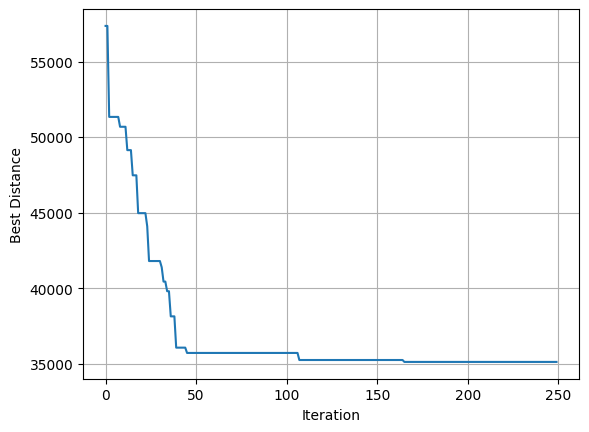

In [22]:
plt.plot(range(len(aco_tsp.costs)), aco_tsp.costs)
plt.xlabel('Iteration')
plt.ylabel('Best Distance')

#plt.xscale('log')
plt.grid(True)
plt.show()

#### 3 opt with ACO

In [23]:
print('3 opt with ACO')
records=[]
for _ in range(repeticiones):
    
    aco_tsp = ACO_TSP(tsp_problem,num_iterations=250)
    best_solution, best_distance = aco_tsp.run()
    
    three_opt_tsp = ThreeOpt_TSP(tsp_problem,init_tour=best_solution)
    best_solution, best_distance = three_opt_tsp.run()
   
    records.append(best_distance)
    
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

3 opt with ACO
Iteration: 0 Best Distance: 57309.38938856678
Iteration: 10 Best Distance: 51247.87828558347
Iteration: 20 Best Distance: 44829.06779467258
Iteration: 30 Best Distance: 39857.682036265476
Iteration: 40 Best Distance: 35947.83021605057
Iteration: 50 Best Distance: 35947.83021605057
Iteration: 60 Best Distance: 35947.83021605057
Iteration: 70 Best Distance: 35947.83021605057
Iteration: 80 Best Distance: 35947.83021605057
Iteration: 90 Best Distance: 35947.83021605057
Iteration: 100 Best Distance: 35031.51989495327
Iteration: 110 Best Distance: 35031.51989495327
Iteration: 120 Best Distance: 35031.51989495327
Iteration: 130 Best Distance: 35031.51989495327
Iteration: 140 Best Distance: 35031.51989495327
Iteration: 150 Best Distance: 35031.51989495327
Iteration: 160 Best Distance: 35031.51989495327
Iteration: 170 Best Distance: 35031.51989495327
Iteration: 180 Best Distance: 35031.51989495327
Iteration: 190 Best Distance: 35031.51989495327
Iteration: 200 Best Distance: 35031

#### GA with ACO

In [24]:
print("Genetic Algorithm with ACO")
records=[]
record_soln=[]
for _ in range(repeticiones):
    aco_tsp = ACO_TSP(tsp_problem,num_iterations=250)
    best_solution, best_distance = aco_tsp.run()
    
    ga_tsp = GA_TSP(tsp_problem, generations=200, initial_tour=best_solution)
    best_solution, best_distance = ga_tsp.run()
    record_soln.append(best_solution)
    records.append(best_distance)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   
    

Genetic Algorithm with ACO
Iteration: 0 Best Distance: 57847.10885911113
Iteration: 10 Best Distance: 48954.26479909397
Iteration: 20 Best Distance: 42580.62346533229
Iteration: 30 Best Distance: 40521.29552279876
Iteration: 40 Best Distance: 38809.54332304659
Iteration: 50 Best Distance: 38255.81425593942
Iteration: 60 Best Distance: 35605.81488695899
Iteration: 70 Best Distance: 35032.84867566698
Iteration: 80 Best Distance: 35032.84867566698
Iteration: 90 Best Distance: 35032.84867566698
Iteration: 100 Best Distance: 35032.84867566698
Iteration: 110 Best Distance: 35032.84867566698
Iteration: 120 Best Distance: 35032.84867566698
Iteration: 130 Best Distance: 35032.84867566698
Iteration: 140 Best Distance: 35032.84867566698
Iteration: 150 Best Distance: 35032.84867566698
Iteration: 160 Best Distance: 35032.84867566698
Iteration: 170 Best Distance: 35032.84867566698
Iteration: 180 Best Distance: 35032.84867566698
Iteration: 190 Best Distance: 35032.84867566698
Iteration: 200 Best Dist

In [25]:
best_record= np.argmin(np.array(records))
our_solution = record_soln[best_record]

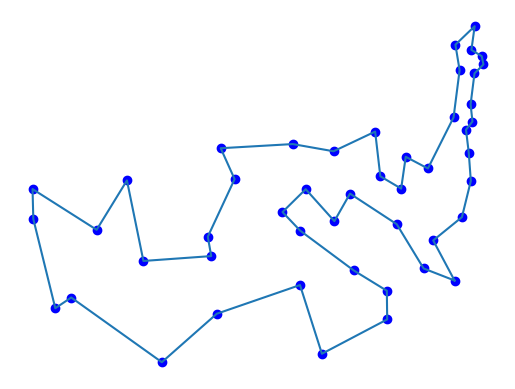

In [26]:
plot_tour(our_solution, cities,'our_soln_att48')

### berlin52

In [70]:
file_name = "data/berlin52.txt"
data=[]
with open(file_name, "r") as f:
    for line in f:
        data.append((line.strip()))

cities=[]
for i in data:
    lst = i.split(" ")
    lst=[x for x in lst if x != '']
   
    x,y =int(float((lst[1]))) , int(float((lst[2])))
    cities.append((x,y))
    
costs_matrix = distance_matrix(cities, cities) 


file_name = "data/berlin52_soln.txt"
data_soln=[]
with open(file_name, "r") as f:
    for line in f:
        data_soln.append((line.strip()))
optimal_soln_= []
for i in data_soln:
    optimal_soln_.append(int(i))
optimal_soln_=optimal_soln_[:-1]
optimal_soln_ =[x-1 for x in optimal_soln_]

tsp_problem = TSPProblem(cities)

optimal_soln_distance = tsp_problem.total_distance(optimal_soln_)
optimal_soln_distance

7544.365901904087

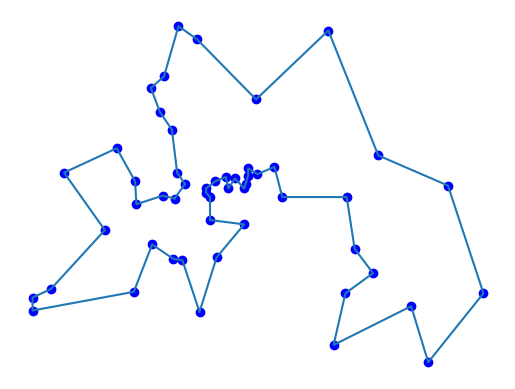

In [28]:
plot_tour(optimal_soln_,cities,'optimal solution of berlin52')

#### CE

In [71]:
repeticiones = 5
print("Cross Entropy")  
records=[]
# repeat the expeiement 5 times
for _ in range(repeticiones):
    cem_tsp = CrossEntropyTSP(costs=costs_matrix , c=1, rho=0.1, d=100, alpha=0.5, seed=np.random.randint(0, 1000))

    # Optimize TSP using Greedy algorithm
    best_solution = cem_tsp.shortest_path()
    best_distance = tsp_problem.total_distance(best_solution)   

    #print progress
    records.append(best_distance)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
    
    
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))

print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Cross Entropy
Iteration: 10 Best Distance: 15272.868683765193
Iteration: 20 Best Distance: 11756.606946076216
Iteration: 30 Best Distance: 10687.381714257213
Iteration: 40 Best Distance: 9824.768703818323
Iteration: 50 Best Distance: 9206.545785953698
Iteration: 60 Best Distance: 8426.171830783951
Iteration: 70 Best Distance: 8215.140378713026
Iteration: 80 Best Distance: 8279.074890569
Iteration: 90 Best Distance: 8287.719825216365
Iteration: 100 Best Distance: 8287.719825216365
Repeticione: 0 Best Distance: 8287.719825216365
Iteration: 10 Best Distance: 15305.03368248091
Iteration: 20 Best Distance: 11609.955883113827
Iteration: 30 Best Distance: 10202.313786486327
Iteration: 40 Best Distance: 9909.896827490982
Iteration: 50 Best Distance: 9096.321742110486
Iteration: 60 Best Distance: 8442.226270314857
Iteration: 70 Best Distance: 8247.109426928699
Iteration: 80 Best Distance: 8214.329151028447
Iteration: 90 Best Distance: 8231.366923423167
Iteration: 100 Best Distance: 8231.3669234

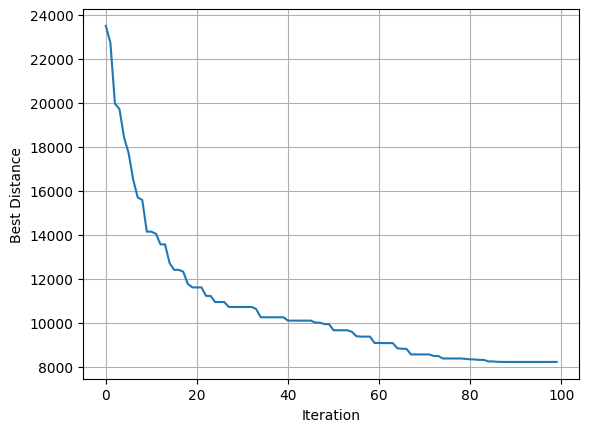

In [64]:

plt.plot(range(len(cem_tsp.cost_hist)),cem_tsp.cost_hist)
plt.xlabel('Iteration')
plt.ylabel('Best Distance')
#plt.xscale('log')
plt.grid(True)
plt.show()

#### greedy

In [29]:

repeticiones = 5
print("Greedy Algorithm")
records=[]
# repet the expeiement 10 times
for _ in range(repeticiones):
    tsp_greedy = TSPGreedy(tsp_problem)

    # Optimize TSP using Greedy algorithm
    best_solution, best_distance = tsp_greedy.optimize()

    #print progress
    records.append(best_distance)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Greedy Algorithm
Repeticione: 0 Best Distance: 9772.430905696207
Repeticione: 1 Best Distance: 9396.88162875504
Repeticione: 2 Best Distance: 9506.045672415641
Repeticione: 3 Best Distance: 9709.416582195205
Repeticione: 4 Best Distance: 9792.138690728236
Averaged best distance  9635.382695958066
Min best distance  9396.88162875504
Max best distance  9792.138690728236
Error 0.27716269614206235


#### 2 opt

In [44]:
print("Two Opt Algorithm")
records=[]
# repet the expeiement 10 times
for _ in range(repeticiones):
    local_search_tsp =TwoOpt_TSP(tsp_problem)

    # Optimize TSP using 2-opt local search
    best_tour, best_distance = local_search_tsp.two_opt()
    # Print results
    #print progress
    records.append(best_distance)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Two Opt Algorithm
Repeticione: 0 Best Distance: 9325.108487449193
Repeticione: 1 Best Distance: 8056.4499716702185
Repeticione: 2 Best Distance: 8792.319309954082
Repeticione: 3 Best Distance: 9384.231942899838
Repeticione: 4 Best Distance: 9341.165580250756
Averaged best distance  8979.855058444818
Min best distance  8056.4499716702185
Max best distance  9384.231942899838
Error 0.1902730030867717


#### 3 opt

In [31]:
print("Three Opt Algorithm")
# repet the expeiement 10 times
records=[]
record_soln=[]
for _ in range(repeticiones):
    three_opt_tsp = ThreeOpt_TSP(tsp_problem)
# Find optimal TSP tour using 3-Opt heuristic
    best_tour, best_distance = three_opt_tsp.run()
    records.append(best_distance)
    record_soln.append(best_tour)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))

print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Three Opt Algorithm
Repeticione: 0 Best Distance: 8695.595433462846
Repeticione: 1 Best Distance: 8944.232956636273
Repeticione: 2 Best Distance: 8284.755862359209
Repeticione: 3 Best Distance: 8441.725118914248
Repeticione: 4 Best Distance: 8842.94749830494
Averaged best distance  8641.851373935502
Min best distance  8284.755862359209
Max best distance  8944.232956636273
Error 0.14547087009054346


#### SA

In [32]:
print('Simulated Annealing Algorithm')
records=[]
for _ in range(repeticiones):
    tsp_sa = TSPSimulatedAnnealing(tsp_problem)
    best_solution, best_distance, costs = tsp_sa.optimize(max_iterations=15000)
    records.append(best_distance)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Simulated Annealing Algorithm
Iteration: 0 Distance: 30472.178203690175 Temperature: 990.0
Iteration: 500 Distance: 15443.633307823347 Temperature: 6.504778211990453
Iteration: 1000 Distance: 13593.762181688515 Temperature: 0.04273953493655127
Iteration: 1500 Distance: 13309.229003037048 Temperature: 0.0002808193895412968
Iteration: 2000 Distance: 13107.111626322008 Temperature: 1.845119036962312e-06
Iteration: 2500 Distance: 12914.868492389965 Temperature: 1.2123323343597228e-08
Iteration: 3000 Distance: 12821.702437135638 Temperature: 7.965609044681468e-11
Iteration: 3500 Distance: 12773.678198975596 Temperature: 5.233789915058397e-13
Iteration: 4000 Distance: 12589.359120452304 Temperature: 3.438852788445183e-15
Iteration: 4500 Distance: 12586.070956328338 Temperature: 2.2594923931839235e-17
Iteration: 5000 Distance: 12557.15635665293 Temperature: 1.4845956453879764e-19
Iteration: 5500 Distance: 12557.15635665293 Temperature: 9.754510512864258e-22
Iteration: 6000 Distance: 12472.953

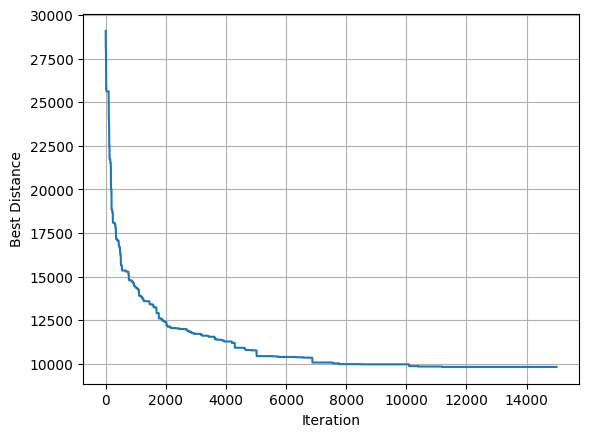

In [33]:
plt.plot(range(len(tsp_sa.costs)), tsp_sa.costs)
plt.xlabel('Iteration')
plt.ylabel('Best Distance')

#plt.xscale('log')
plt.grid(True)
plt.show()

#### TS 

In [34]:
print("Tabu Search Algorithm")
records=[]
for _ in range(repeticiones):

    ts_tsp = TabuSearchTSP(tsp_problem,num_iterations=100)
    best_solution, best_distance = ts_tsp.run()
    records.append(best_distance)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Tabu Search Algorithm
Iteration: 0 Best Distance: 26391.75183812024
Iteration: 10 Best Distance: 16010.495147563868
Iteration: 20 Best Distance: 12888.492434672109
Iteration: 30 Best Distance: 11327.270119295854
Iteration: 40 Best Distance: 10765.863540226152
Iteration: 50 Best Distance: 10632.577124282743
Iteration: 60 Best Distance: 10002.246016768968
Iteration: 70 Best Distance: 9934.497585579795
Iteration: 80 Best Distance: 9934.497585579795
Iteration: 90 Best Distance: 9871.156415386775
Repeticione: 0 Best Distance: 9743.257888099997
Iteration: 0 Best Distance: 26852.082686688183
Iteration: 10 Best Distance: 16081.497064727744
Iteration: 20 Best Distance: 11985.147788948398
Iteration: 30 Best Distance: 10101.315710500738
Iteration: 40 Best Distance: 9741.366554716098
Iteration: 50 Best Distance: 9717.752711277244
Iteration: 60 Best Distance: 9717.752711277244
Iteration: 70 Best Distance: 9717.752711277244
Iteration: 80 Best Distance: 9717.752711277244
Iteration: 90 Best Distance: 

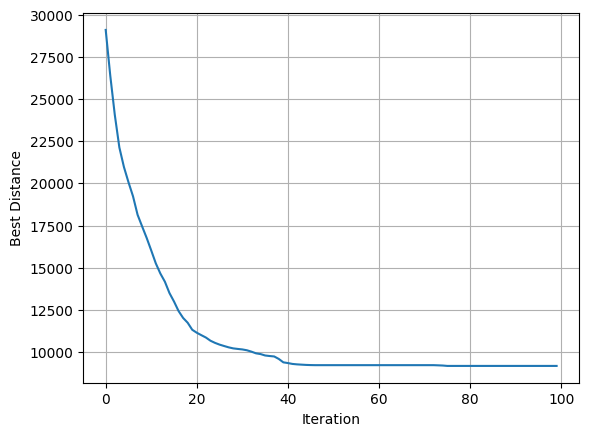

In [35]:

plt.plot(range(len(ts_tsp.costs)),ts_tsp.costs)
plt.xlabel('Iteration')
plt.ylabel('Best Distance')
#plt.xscale('log')
plt.grid(True)
plt.show()

#### GA

In [36]:
print("Genetic Algorithm")


records=[]
for _ in range(repeticiones):
   ga_tsp = GA_TSP(tsp_problem,generations=200)
   best_solution, best_distance = ga_tsp.run()
   records.append(best_distance)
   print("Repeticione:", _ , "Best Distance:",  best_distance )
   
   
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Genetic Algorithm
Generation: 0 Best Distance: 22104.173901685816
Generation: 10 Best Distance: 16738.972438150082
Generation: 20 Best Distance: 14051.339079043955
Generation: 30 Best Distance: 12675.825646990843
Generation: 40 Best Distance: 12427.60526376931
Generation: 50 Best Distance: 12369.766680430435
Generation: 60 Best Distance: 12109.695279151723
Generation: 70 Best Distance: 11993.526104889448
Generation: 80 Best Distance: 11993.526104889448
Generation: 90 Best Distance: 11851.06983135043
Generation: 100 Best Distance: 11677.928930509246
Generation: 110 Best Distance: 11677.928930509246
Generation: 120 Best Distance: 11387.12462785113
Generation: 130 Best Distance: 11387.12462785113
Generation: 140 Best Distance: 11313.571101940546
Generation: 150 Best Distance: 11313.571101940546
Generation: 160 Best Distance: 11313.571101940546
Generation: 170 Best Distance: 11313.571101940546
Generation: 180 Best Distance: 11313.571101940546
Generation: 190 Best Distance: 11313.5711019405

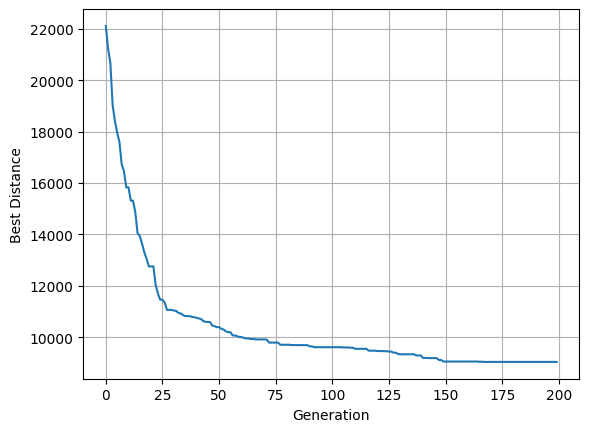

In [37]:
plt.plot(range(len(ga_tsp.costs)), ga_tsp.costs)
plt.xlabel('Generation')
plt.ylabel('Best Distance')

#plt.xscale('log')
plt.grid(True)
plt.show()

#### ACO

In [38]:
print("Ant Colony Optimization Algorithm")  
records=[]
record_soln=[]
for _ in range(repeticiones):
   
   aco_tsp = ACO_TSP(tsp_problem,num_iterations=250)
   best_solution, best_distance = aco_tsp.run()
   records.append(best_distance)
   record_soln.append(best_solution)
   print("Repeticione:", _ , "Best Distance:",  best_distance )
   
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Ant Colony Optimization Algorithm
Iteration: 0 Best Distance: 13401.387141204526
Iteration: 10 Best Distance: 9967.98431924848
Iteration: 20 Best Distance: 8630.103387149484
Iteration: 30 Best Distance: 8630.103387149484
Iteration: 40 Best Distance: 8295.095040626054
Iteration: 50 Best Distance: 8192.065885219356
Iteration: 60 Best Distance: 8148.834011395347
Iteration: 70 Best Distance: 8039.606266324596
Iteration: 80 Best Distance: 7907.074458658632
Iteration: 90 Best Distance: 7907.074458658632
Iteration: 100 Best Distance: 7907.074458658632
Iteration: 110 Best Distance: 7777.394662956036
Iteration: 120 Best Distance: 7777.394662956036
Iteration: 130 Best Distance: 7777.394662956036
Iteration: 140 Best Distance: 7777.394662956036
Iteration: 150 Best Distance: 7777.394662956036
Iteration: 160 Best Distance: 7777.394662956036
Iteration: 170 Best Distance: 7777.394662956036
Iteration: 180 Best Distance: 7777.394662956036
Iteration: 190 Best Distance: 7777.394662956036
Iteration: 200 Be

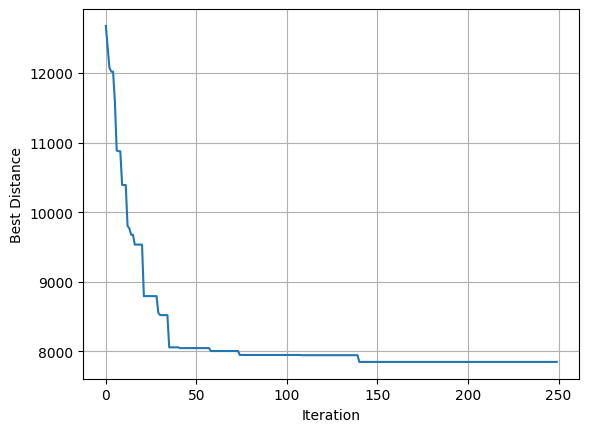

In [39]:
plt.plot(range(len(aco_tsp.costs)), aco_tsp.costs)
plt.xlabel('Iteration')
plt.ylabel('Best Distance')

#plt.xscale('log')
plt.grid(True)
plt.show()

#### 3 opt with ACO

In [40]:
print('3 opt with ACO')
records=[]
for _ in range(repeticiones):
    
    aco_tsp = ACO_TSP(tsp_problem,num_iterations=250)
    best_solution, best_distance = aco_tsp.run()
    
    three_opt_tsp = ThreeOpt_TSP(tsp_problem,init_tour=best_solution)
    best_solution, best_distance = three_opt_tsp.run()
   
    records.append(best_distance)
    
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

3 opt with ACO
Iteration: 0 Best Distance: 13128.7680181911
Iteration: 10 Best Distance: 9964.903602767119
Iteration: 20 Best Distance: 9397.03944958587
Iteration: 30 Best Distance: 8540.736681755105
Iteration: 40 Best Distance: 8264.484496487801
Iteration: 50 Best Distance: 8170.976326182262
Iteration: 60 Best Distance: 7985.660596399117
Iteration: 70 Best Distance: 7985.660596399117
Iteration: 80 Best Distance: 7985.660596399117
Iteration: 90 Best Distance: 7985.380351759493
Iteration: 100 Best Distance: 7985.380351759493
Iteration: 110 Best Distance: 7985.380351759493
Iteration: 120 Best Distance: 7864.697205435724
Iteration: 130 Best Distance: 7864.697205435724
Iteration: 140 Best Distance: 7864.697205435724
Iteration: 150 Best Distance: 7864.697205435724
Iteration: 160 Best Distance: 7864.697205435724
Iteration: 170 Best Distance: 7864.697205435724
Iteration: 180 Best Distance: 7864.697205435724
Iteration: 190 Best Distance: 7864.697205435724
Iteration: 200 Best Distance: 7851.952

#### GA with ACO

In [41]:
print("Genetic Algorithm with ACO")
records=[]
record_soln=[]
for _ in range(repeticiones):
    aco_tsp = ACO_TSP(tsp_problem,num_iterations=250)
    best_solution, best_distance = aco_tsp.run()
    
    ga_tsp = GA_TSP(tsp_problem, generations=200, initial_tour=best_solution)
    best_solution, best_distance = ga_tsp.run()
    record_soln.append(best_solution)
    records.append(best_distance)
    print("Repeticione:", _ , "Best Distance:",  best_distance )
print("Averaged best distance " , sum(records)/len(records))
print("Min best distance " , min(records))
print("Max best distance " , max(records))
print('Error', abs(optimal_soln_distance - sum(records)/len(records))/optimal_soln_distance)   

Genetic Algorithm with ACO
Iteration: 0 Best Distance: 12969.77012231975
Iteration: 10 Best Distance: 10920.364413864649
Iteration: 20 Best Distance: 8424.815386396727
Iteration: 30 Best Distance: 8268.650051237571
Iteration: 40 Best Distance: 8163.892185387929
Iteration: 50 Best Distance: 8102.767976627608
Iteration: 60 Best Distance: 7896.954818516706
Iteration: 70 Best Distance: 7896.954818516706
Iteration: 80 Best Distance: 7896.954818516706
Iteration: 90 Best Distance: 7896.954818516706
Iteration: 100 Best Distance: 7896.954818516706
Iteration: 110 Best Distance: 7896.954818516706
Iteration: 120 Best Distance: 7896.954818516706
Iteration: 130 Best Distance: 7896.954818516706
Iteration: 140 Best Distance: 7896.954818516706
Iteration: 150 Best Distance: 7896.954818516706
Iteration: 160 Best Distance: 7896.954818516706
Iteration: 170 Best Distance: 7896.954818516706
Iteration: 180 Best Distance: 7896.954818516706
Iteration: 190 Best Distance: 7896.954818516706
Iteration: 200 Best Dis

In [42]:
best_record= np.argmin(np.array(records))
our_solution = record_soln[best_record]

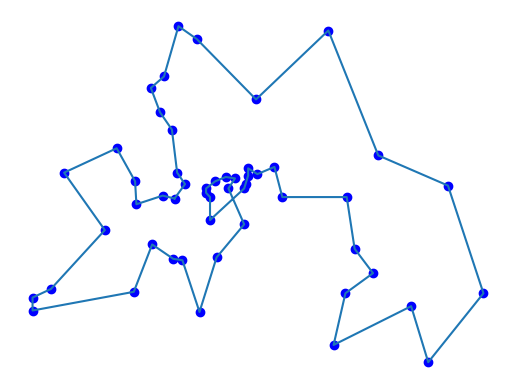

In [43]:
plot_tour(best_solution, cities,'our_soln_berlin52')